In [1]:
import numpy as np
import pandas as pd
from tensorflow import keras
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Splitting the Data

In [2]:
#Loading the dataset
housing = fetch_california_housing()

In [3]:
#Creating training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(housing.data, housing.target)

In [4]:
#Creating training and validation datasets
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train)

In [5]:
#Normalizing the training, validation and testing features using Standard Scaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.fit_transform(X_valid)
X_test = scaler.fit_transform(X_test)

# Creating Deep and Wide NN using Functional API

In [6]:
#Creating a Functional Model 
input_A = keras.layers.Input(shape=[5], name="wide-input") #Creating input features for wide path
input_B = keras.layers.Input(shape=[6], name="deep-input") #Creating input features for deep path
hidden1 = keras.layers.Dense(30, activation="relu")(input_B) #Using ReLU for Dense First Hidden layer with 30 neurons (for Deep Path)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1) #Using ReLU for Dense Second Hidden layer with 30 neurons (for Deep Path)
concat = keras.layers.Concatenate()([input_A, hidden2]) #Joining the Input layer (for Wide Path) with Second Hidden layer for combined wide and deep path outputs
output = keras.layers.Dense(1, name="main-output")(concat) #Preparing output using the combined output
aux_output = keras.layers.Dense(1, name="aux-output")(hidden2) #Preparing an auxilary output for regularization purposes
model = keras.Model(inputs=[input_A, input_B], outputs=[output, aux_output]) #Preparing model using the inputs and outputs obtained

In [7]:
#Viewing the summary of the model
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
deep-input (InputLayer)         [(None, 6)]          0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 30)           210         deep-input[0][0]                 
__________________________________________________________________________________________________
wide-input (InputLayer)         [(None, 5)]          0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 30)           930         dense[0][0]                      
______________________________________________________________________________________________

# Compiling the Model

In [8]:
#Compiling the prepared model
model.compile(loss=["mse","mse"],
              optimizer=keras.optimizers.SGD(learning_rate=0.001),
              loss_weights=[0.9,0.1] #Assigning weightage for main and auxilary outputs
)

# Fitting Model on Training Set

In [9]:
#Creating training, testing and validation sets for deep and wide paths
X_train_A, X_train_B = X_train[:, :5], X_train[:, 2:]
X_valid_A, X_valid_B = X_valid[:, :5], X_valid[:, 2:]
X_test_A, X_test_B = X_test[:, :5], X_test[:, 2:]
X_new_A, X_new_B = X_test_A[:3], X_test_B[:3]

In [10]:
#Training the model (Added two times y_labels as there are 2 outputs)
history = model.fit((X_train_A, X_train_B), [y_train, y_train], epochs=20, validation_data=((X_valid_A, X_valid_B), [y_valid, y_valid]))

Epoch 1/20
363/363 [==============================] - 2s 3ms/step - loss: 3.4390 - main-output_loss: 3.1719 - aux-output_loss: 5.8425 - val_loss: 1.2900 - val_main-output_loss: 1.0205 - val_aux-output_loss: 3.7158
Epoch 2/20
363/363 [==============================] - 1s 2ms/step - loss: 1.2219 - main-output_loss: 0.9819 - aux-output_loss: 3.3825 - val_loss: 0.8997 - val_main-output_loss: 0.7388 - val_aux-output_loss: 2.3476
Epoch 3/20
363/363 [==============================] - 1s 2ms/step - loss: 0.9226 - main-output_loss: 0.7718 - aux-output_loss: 2.2803 - val_loss: 0.7455 - val_main-output_loss: 0.6383 - val_aux-output_loss: 1.7103
Epoch 4/20
363/363 [==============================] - 1s 2ms/step - loss: 0.7707 - main-output_loss: 0.6700 - aux-output_loss: 1.6765 - val_loss: 0.6657 - val_main-output_loss: 0.5819 - val_aux-output_loss: 1.4197
Epoch 5/20
363/363 [==============================] - 1s 2ms/step - loss: 0.7049 - main-output_loss: 0.6210 - aux-output_loss: 1.4603 - val_loss

In [11]:
#Viewing the parameters for the model
history.params

{'epochs': 20, 'steps': 363, 'verbose': 1}

# Plotting the Model

In [12]:
#Using pandas dataframe to create a dataframe of the losses and extra parameters
history_df = pd.DataFrame(history.history)
history_df.head()

,loss,main-output_loss,aux-output_loss,val_loss,val_main-output_loss,val_aux-output_loss
0,2.360488,2.060776,5.057878,1.289992,1.020454,3.715840
1,1.113636,0.903221,3.007365,0.899716,0.738837,2.347631
2,0.866477,0.733850,2.060114,0.745499,0.638300,1.710284
3,0.756182,0.660164,1.620341,0.665675,0.581893,1.419708
4,0.694494,0.614475,1.414659,0.619826,0.546300,1.281561


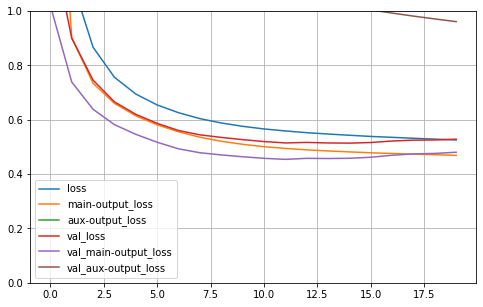

In [13]:
#Visualizing the learning curve for the model
history_df.plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

# Evaluating the Model

In [14]:
#Evaluating Model for the test set
total_loss, main_loss, aux_loss = model.evaluate((X_test_A, X_test_B), [y_test, y_test])

162/162 [==============================] - 0s 1ms/step - loss: 0.5088 - main-output_loss: 0.4539 - aux-output_loss: 1.0026


# Predicting Values from the Model

In [15]:
#Creating new instances from the test set
X_new_A, X_new_B

(array([[-0.86869904,  0.74264428, -0.71074842, -0.03949193,  0.02161238],
        [ 0.69013346, -1.72261356, -0.29033245, -0.48555833, -1.01855871],
        [-0.2372859 ,  0.50407094,  0.19577272,  0.21987945,  1.85906256]]),
 array([[-0.71074842, -0.03949193,  0.02161238, -0.06643809, -0.71655897,
          0.73323408],
        [-0.29033245, -0.48555833, -1.01855871,  0.05008395,  0.27718327,
         -0.09019282],
        [ 0.19577272,  0.21987945,  1.85906256, -0.11868985, -0.07272597,
          1.15486833]]))

In [16]:
#Computing probabilities for the new set
y_proba_main, y_proba_aux = model.predict((X_new_A, X_new_B))
y_proba_main.round(2), y_proba_aux.round(2)

(array([[1.7 ],
        [1.94],
        [1.12]], dtype=float32), array([[1.91],
        [1.72],
        [1.31]], dtype=float32))